In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import holidays
import matplotlib.pyplot as plt
import xgboost as xgb

/home/mry/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
!pwd

/home/mry/ml_forecasting_system/notebooks/modelling


In [14]:
# Load the data (replace with your path)
sales_country1 = pd.read_excel('/home/mry/ml_forecasting_system/data/raw/SalesCountry1.xlsx')
sales_country1['National'] = sales_country1[['Region 1', 'Region 2', 'Region 3']].sum(axis=1)
sales_country2 = pd.read_excel('/home/mry/ml_forecasting_system/data/raw/SalesCountry1.xlsx')

# Display first few rows for Country 1 and Country 2
print("Country 1 Data:")
print(sales_country1.head())

print("Country 2 Data:")
print(sales_country2.head())

Country 1 Data:
        Date  Region 1  Region 2  Region 3  National
0 2021-05-03   9001.44   1619.94    273.98  10895.36
1 2021-05-10  56345.45   9939.09   1584.03  67868.57
2 2021-05-17  61777.17  10835.51   1643.88  74256.56
3 2021-05-24  57489.25   9888.55   1598.66  68976.46
4 2021-05-31  58345.77  10048.15   1512.21  69906.13
Country 2 Data:
        Date  Region 1  Region 2  Region 3
0 2021-05-03   9001.44   1619.94    273.98
1 2021-05-10  56345.45   9939.09   1584.03
2 2021-05-17  61777.17  10835.51   1643.88
3 2021-05-24  57489.25   9888.55   1598.66
4 2021-05-31  58345.77  10048.15   1512.21


# Country 1: Aggregate Modelling using Prophet

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split data (train: 80%, test: 20%) based on 'Date' column to maintain order in time series
train_size = int(0.8 * len(sales_country1))
train_data = sales_country1.iloc[:train_size]
test_data = sales_country1.iloc[train_size:]

# Display the number of rows in train and test sets
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 121
Test set size: 31


In [16]:
# Prepare data for Prophet
train_data_prophet = train_data[['Date', 'National']].rename(columns={'Date': 'ds', 'National': 'y'})

us_holidays = holidays.US(years=[2019, 2020, 2021, 2022])
holiday_list = pd.DataFrame(list(us_holidays.items()), columns=['ds', 'holiday'])

# Initialize Prophet with custom parameters for tuning
model = Prophet(
    seasonality_mode='additive',  
    yearly_seasonality=True,  # Enable yearly seasonality explicitly
    weekly_seasonality=True,  # Enable weekly seasonality
    changepoint_prior_scale=0.005,  # Adjust sensitivity to trend changes (lower values = less sensitive)
    holidays = holiday_list
)

# Fit the model
model.fit(train_data_prophet)

# Forecast 12 weeks into the future
future = model.make_future_dataframe(periods=len(test_data), freq='W-MON')
forecast = model.predict(future)

# Extract the predicted values for the test period
forecast_test_period = forecast[forecast['ds'].isin(test_data['Date'])]

# Actual vs predicted values for the test set
actual_values = test_data['National'].values
predicted_values = forecast_test_period['yhat'].values

# Evaluate performance using MAPE
mape = mean_absolute_percentage_error(actual_values, predicted_values)

# Display the tuned MAPE
print(f"Tuned Mean Absolute Percentage Error (MAPE): {mape}")


09:24:56 - cmdstanpy - INFO - Chain [1] start processing
09:24:56 - cmdstanpy - INFO - Chain [1] done processing
09:24:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:24:56 - cmdstanpy - INFO - Chain [1] start processing
09:24:57 - cmdstanpy - INFO - Chain [1] done processing


Tuned Mean Absolute Percentage Error (MAPE): 0.20960000008200855


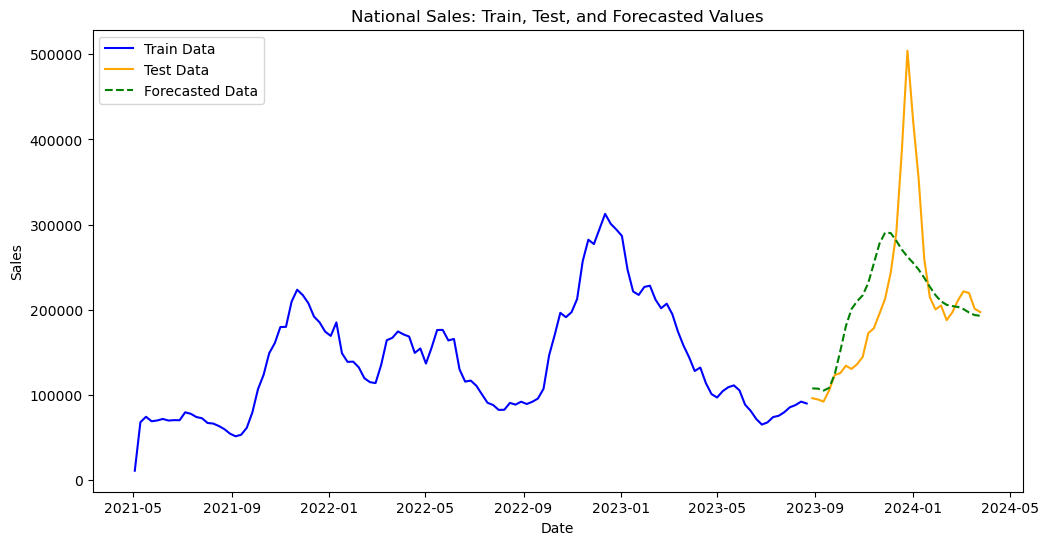

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['National'], label='Train Data', color='blue')

# Plot actual National Sales (Test)
plt.plot(test_data['Date'], test_data['National'], label='Test Data', color='orange')

# Plot forecasted National Sales (including predictions for the test period)
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Forecasted Data', color='green', linestyle='dashed')

# Add labels and title
plt.title('National Sales: Train, Test, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Show the plot
plt.show()

# Regional forecasting

In [18]:
def create_lagged_features(data, region_columns, national_column, num_lags=7):
    """
    Creates lagged features for regional sales and adds the national forecast as a feature.
    data: DataFrame containing regional sales and national forecast.
    region_columns: List of regional sales column names (e.g., ['Region 1', 'Region 2']).
    national_column: Column name for national sales forecast.
    num_lags: Number of lagged features to create (default is 3).
    
    Returns: DataFrame with lagged features added.
    """
    # Create lagged features for each region
    for region in region_columns:
        for lag in range(1, num_lags + 1):
            data[f'{region}_lag{lag}'] = data[region].shift(lag)
    
    # Use the national forecast as a feature
    data['National_forecast'] = data[national_column]
    
    # Drop rows with NaN values resulting from lagging
    data = data.dropna()
    
    return data

# Define the columns for regional sales
region_columns = ['Region 1', 'Region 2', 'Region 3']

# Assume 'National' is the actual sales column, and we're using the forecast from Prophet
data_with_lags = create_lagged_features(sales_country1, region_columns, 'National',num_lags=4)

# Display the first few rows of the data with lagged features
data_with_lags.head()

,Date,Region 1,Region 2,Region 3,National,Region 1_lag1,Region 1_lag2,Region 1_lag3,Region 1_lag4,Region 2_lag1,Region 2_lag2,Region 2_lag3,Region 2_lag4,Region 3_lag1,Region 3_lag2,Region 3_lag3,Region 3_lag4,National_forecast
4,2021-05-31,58345.77,10048.15,1512.21,69906.13,57489.25,61777.17,56345.45,9001.44,9888.55,10835.51,9939.09,1619.94,1598.66,1643.88,1584.03,273.98,69906.13
5,2021-06-07,59768.87,10380.65,1578.71,71728.23,58345.77,57489.25,61777.17,56345.45,10048.15,9888.55,10835.51,9939.09,1512.21,1598.66,1643.88,1584.03,71728.23
6,2021-06-14,58053.17,10138.59,1635.90,69827.66,59768.87,58345.77,57489.25,61777.17,10380.65,10048.15,9888.55,10835.51,1578.71,1512.21,1598.66,1643.88,69827.66
7,2021-06-21,58631.72,10166.52,1512.21,70310.45,58053.17,59768.87,58345.77,57489.25,10138.59,10380.65,10048.15,9888.55,1635.90,1578.71,1512.21,1598.66,70310.45
8,2021-06-28,58735.46,9968.35,1513.54,70217.35,58631.72,58053.17,59768.87,58345.77,10166.52,10138.59,10380.65,10048.15,1512.21,1635.90,1578.71,1512.21,70217.35


## Region 1

In [22]:
# Step 1: Split the data into features (X) and target (y)
X = sales_country1.drop(columns=region_columns)  # Features are all except the regional sales
y = sales_country1[region_columns]  # Target is the regional sales

# Step 2: Perform a train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 3: Create lagged features separately for training and testing sets
# For the training set
train_data_with_lags = create_lagged_features(X_train.join(y_train), region_columns, 'National', num_lags=4)

# For the test set
test_data_with_lags = create_lagged_features(X_test.join(y_test), region_columns, 'National', num_lags=4)

# Step 4: Drop the 'Date' column since XGBoost cannot handle datetime columns
X_train_lags = train_data_with_lags.drop(columns=['Date'] + region_columns)  # Features
y_train_lags = train_data_with_lags[region_columns]  # Target

X_test_lags = test_data_with_lags.drop(columns=['Date'] + region_columns)  # Features
y_test_lags = test_data_with_lags[region_columns]  # Target

# Step 5: Train model for Region 1, ensuring no leakage
X_train_region1 = X_train_lags.drop(columns=[col for col in X_train_lags.columns if 'Region 2' in col or 'Region 3' in col])
X_test_region1 = X_test_lags.drop(columns=[col for col in X_test_lags.columns if 'Region 2' in col or 'Region 3' in col])

# Now fit the XGBoost model for Region 1
model_region1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Fit the model on training data (Region 1)
model_region1.fit(X_train_region1, y_train_lags['Region 1'])

# Make predictions for the test set (Region 1)
y_pred_region1 = model_region1.predict(X_test_region1)

# Calculate MAPE for Region 1
mape_region1 = mean_absolute_percentage_error(y_test_lags['Region 1'], y_pred_region1)

print(f"MAPE for Region 1: {mape_region1}")


MAPE for Region 1: 0.06346559188120648


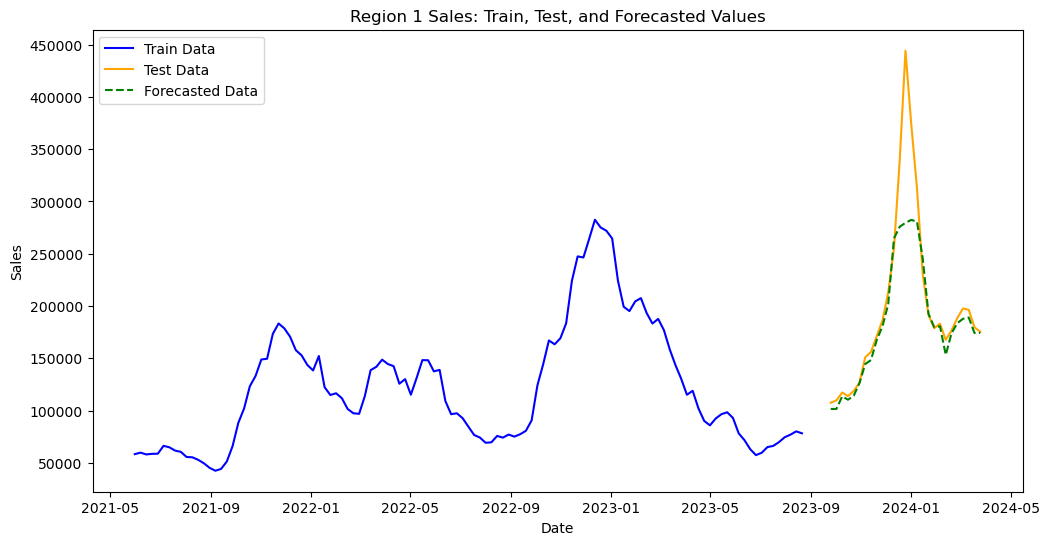

In [24]:
# Step 1: Extract the dates for train and test sets from the original data
dates_train = train_data_with_lags['Date']  # Dates corresponding to the training set
dates_test = test_data_with_lags['Date']    # Dates corresponding to the test set

# Step 2: Plot the actual values (train + test) and the forecasted values for Region 1
plt.figure(figsize=(12, 6))

# Plot actual Region 1 Sales (Train)
plt.plot(dates_train, y_train_lags['Region 1'], label='Train Data', color='blue')

# Plot actual Region 1 Sales (Test)
plt.plot(dates_test, y_test_lags['Region 1'], label='Test Data', color='orange')

# Plot forecasted Region 1 Sales (Predicted values)
plt.plot(dates_test, y_pred_region1, label='Forecasted Data', color='green', linestyle='dashed')

# Step 3: Add labels and title
plt.title('Region 1 Sales: Train, Test, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Step 4: Show the plot
plt.show()


## region 2

In [27]:
# Train model for Region 2 (and ensure no data leakage)
X_train_region2 = X_train_lags.drop(columns=[col for col in X_train_lags.columns if 'Region 1' in col or 'Region 3' in col])
X_test_region2 = X_test_lags.drop(columns=[col for col in X_test_lags.columns if 'Region 1' in col or 'Region 3' in col])

# Now fit the XGBoost model for Region 2
model_region2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Fit the model on training data (Region 2)
model_region2.fit(X_train_region2, y_train_lags['Region 2'])

# Make predictions for the test set (Region 2)
y_pred_region2 = model_region2.predict(X_test_region2)

# Calculate MAPE for Region 2
mape_region2 = mean_absolute_percentage_error(y_test_lags['Region 2'], y_pred_region2)

print(f"MAPE for Region 2: {mape_region2}")


MAPE for Region 2: 0.1380695763231355


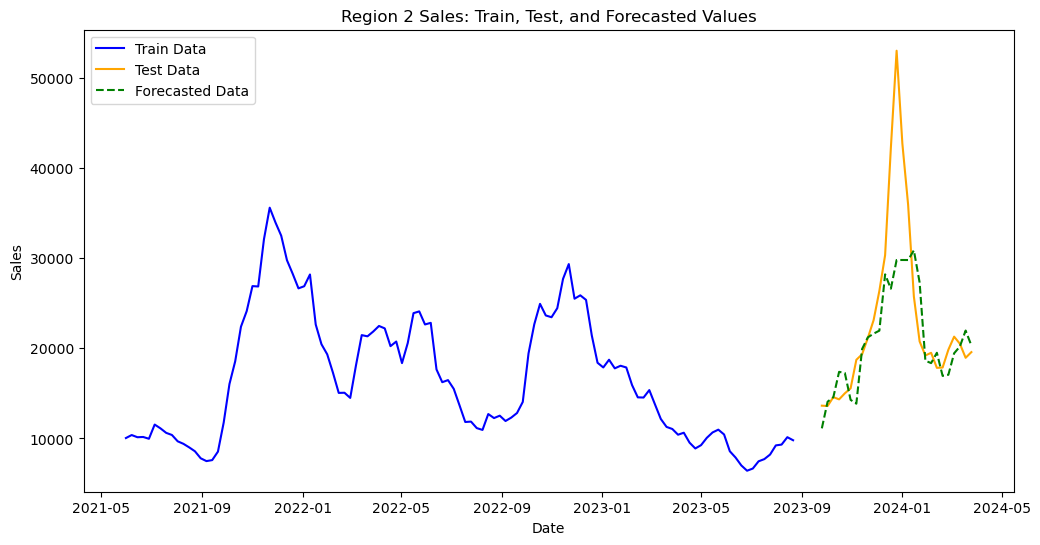

In [28]:
# Step 1: Extract the correct dates for the training and test sets
dates_train = train_data_with_lags['Date']  # Dates corresponding to the training set
dates_test = test_data_with_lags['Date']    # Dates corresponding to the test set

# Step 2: Plot the actual values (train + test) and the forecasted values for Region 2
plt.figure(figsize=(12, 6))

# Plot actual Region 2 Sales (Train)
plt.plot(dates_train, y_train_lags['Region 2'], label='Train Data', color='blue')

# Plot actual Region 2 Sales (Test)
plt.plot(dates_test, y_test_lags['Region 2'], label='Test Data', color='orange')

# Plot forecasted Region 2 Sales (Predicted values)
plt.plot(dates_test, y_pred_region2, label='Forecasted Data', color='green', linestyle='dashed')

# Step 3: Add labels and title
plt.title('Region 2 Sales: Train, Test, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Step 4: Show the plot
plt.show()


## Region 3

In [29]:
# Train model for Region 2 (and ensure no data leakage)
X_train_region3 = X_train_lags.drop(columns=[col for col in X_train_lags.columns if 'Region 1' in col or 'Region 2' in col])
X_test_region3 = X_test_lags.drop(columns=[col for col in X_test_lags.columns if 'Region 1' in col or 'Region 2' in col])

# Now fit the XGBoost model for Region 2
model_region3 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Fit the model on training data (Region 2)
model_region3.fit(X_train_region3, y_train_lags['Region 3'])

# Make predictions for the test set (Region 2)
y_pred_region3 = model_region3.predict(X_test_region3)

# Calculate MAPE for Region 2
mape_region3 = mean_absolute_percentage_error(y_test_lags['Region 3'], y_pred_region3)

print(f"MAPE for Region 3: {mape_region3}")


MAPE for Region 3: 0.31554005625044673


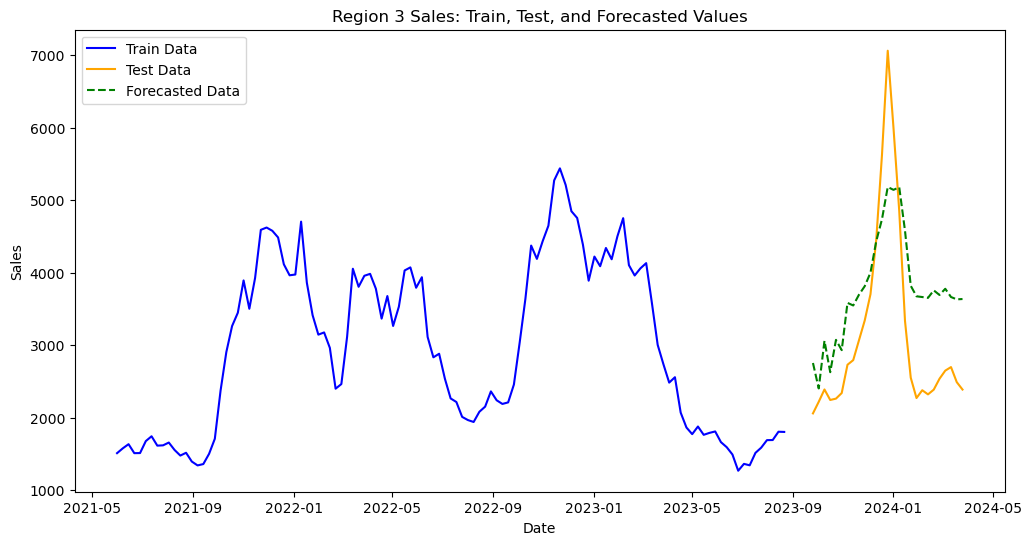

In [30]:
# Step 1: Extract the correct dates for the training and test sets
dates_train = train_data_with_lags['Date']  # Dates corresponding to the training set
dates_test = test_data_with_lags['Date']    # Dates corresponding to the test set

# Step 2: Plot the actual values (train + test) and the forecasted values for Region 3
plt.figure(figsize=(12, 6))

# Plot actual Region 3 Sales (Train)
plt.plot(dates_train, y_train_lags['Region 3'], label='Train Data', color='blue')

# Plot actual Region 3 Sales (Test)
plt.plot(dates_test, y_test_lags['Region 3'], label='Test Data', color='orange')

# Plot forecasted Region 3 Sales (Predicted values)
plt.plot(dates_test, y_pred_region3, label='Forecasted Data', color='green', linestyle='dashed')

# Step 3: Add labels and title
plt.title('Region 3 Sales: Train, Test, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Step 4: Show the plot
plt.show()


# Coutnry 2: Aggregated forecasting

Since we observed that country 2 has some missing dates, so lets fill those dates with backward filling technique

In [51]:
def fill_missing_dates_with_bfill(data, date_col='Date'):
    """
    Fills missing dates in the time series and applies backward fill to handle missing sales data.
    data: DataFrame containing the sales data.
    date_col: Name of the column that contains the date information.
    
    Returns: DataFrame with missing dates filled and values backward filled.
    """
    # Step 1: Ensure the Date column is in datetime format
    data[date_col] = pd.to_datetime(data[date_col])
    
    # Step 2: Create a complete date range (weekly frequency in this case)
    full_date_range = pd.date_range(start=data[date_col].min(), 
                                    end=data[date_col].max(), 
                                    freq='W-MON')  # Weekly data
    
    # Step 3: Reindex the DataFrame with the full date range and apply backward fill
    data = data.set_index(date_col).reindex(full_date_range)
    data = data.bfill()  # Backward fill missing values
    
    # Step 4: Reset index to get 'Date' back as a column
    data = data.reset_index().rename(columns={'index': date_col})
    
    return data

# Example usage with Country 2 data
sales_country2_filled = fill_missing_dates_with_bfill(sales_country2)

# Display the first few rows of the filled data
print(sales_country2_filled.head())


        Date    Region 1    Region 2    Region 3     National
0 2019-01-07  10827.2000  54055.7500  34619.6250   99502.5750
1 2019-01-14  10523.3750  51052.6875  30550.1000   92126.1625
2 2019-01-21  12860.5125  57290.2000  36072.2875  106223.0000
3 2019-01-28  14841.4625  62758.1750  41300.5375  118900.1750
4 2019-02-04  15490.0625  71519.6625  45111.7875  132121.5125


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split data (train: 80%, test: 20%) based on 'Date' column to maintain order in time series
train_size = int(0.8 * len(sales_country2_filled))
train_data = sales_country2_filled.iloc[:train_size]
test_data = sales_country2_filled.iloc[train_size:]

# Display the number of rows in train and test sets
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")



Train set size: 190
Test set size: 48


In [53]:
# Prepare data for Prophet
train_data_prophet = train_data[['Date', 'National']].rename(columns={'Date': 'ds', 'National': 'y'})

us_holidays = holidays.US(years=[2019, 2020, 2021, 2022])
holiday_list = pd.DataFrame(list(us_holidays.items()), columns=['ds', 'holiday'])

# Initialize Prophet with custom parameters for tuning
model = Prophet(
    seasonality_mode='additive',  
    yearly_seasonality=True,  # Enable yearly seasonality explicitly
    weekly_seasonality=True,  # Enable weekly seasonality
    changepoint_prior_scale=0.005,  # Adjust sensitivity to trend changes (lower values = less sensitive)
    holidays = holiday_list
)

# Fit the model
model.fit(train_data_prophet)

# Forecast 12 weeks into the future
future = model.make_future_dataframe(periods=len(test_data), freq='W-MON')
forecast = model.predict(future)

# Extract the predicted values for the test period
forecast_test_period = forecast[forecast['ds'].isin(test_data['Date'])]

# Actual vs predicted values for the test set
actual_values = test_data['National'].values
predicted_values = forecast_test_period['yhat'].values

# Evaluate performance using MAPE
mape = mean_absolute_percentage_error(actual_values, predicted_values)

# Display the tuned MAPE
print(f"Tuned Mean Absolute Percentage Error (MAPE): {mape}")


22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:09 - cmdstanpy - INFO - Chain [1] done processing


Tuned Mean Absolute Percentage Error (MAPE): 0.18150976435487862


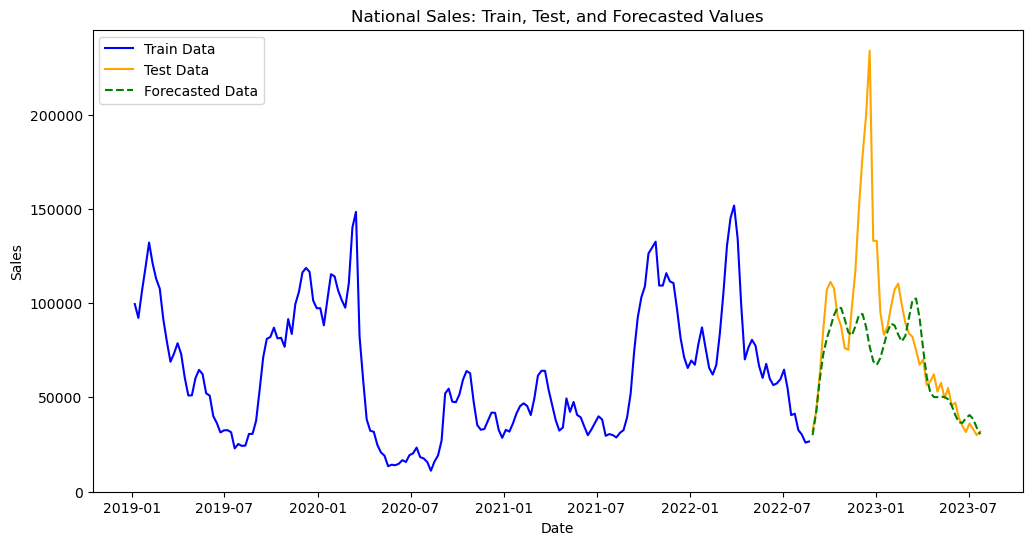

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['National'], label='Train Data', color='blue')

# Plot actual National Sales (Test)
plt.plot(test_data['Date'], test_data['National'], label='Test Data', color='orange')

# Plot forecasted National Sales (including predictions for the test period)
plt.plot(forecast_test_period['ds'], forecast_test_period['yhat'], label='Forecasted Data', color='green', linestyle='dashed')

# Add labels and title
plt.title('National Sales: Train, Test, and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

# Show the plot
plt.show()